## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive
drive.mount('/content/drive')

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01" # import data
start_date = "2010-01-01" # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
UNIVERSE = ['SET']
MODEL_NAME = "Change Trend"

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- SMAV(20) < SMAV(90)
- SMAV(10) > SMAV(20)
- %Price Up In 90 days > 10
- Average Trading 20 days > 2e7

Ranking: top 10 stock with %Price Up In 90 days

In [ ]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

sma_10_df = ssc.ta.sma(close_df, 10)
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)

pct_90d_df = ssc.ta.roc(close_df, 90)

In [ ]:
# sma cond
sma_10_cond = sma_10_df > sma_20_df
sma_20_cond = sma_20_df < sma_90_df

# pct change 90 days > 10%
pct_90d_cond = pct_90d_df > 10

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = sma_10_cond & sma_20_cond & pct_90d_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
# replace values that signal == True
pct_90d_df = pd.DataFrame(np.where((signal_df == True)
         , pct_90d_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking pct change
# 10 highest pct change
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pct_90d_df, quantity=pos_num, ascending=False
)  

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

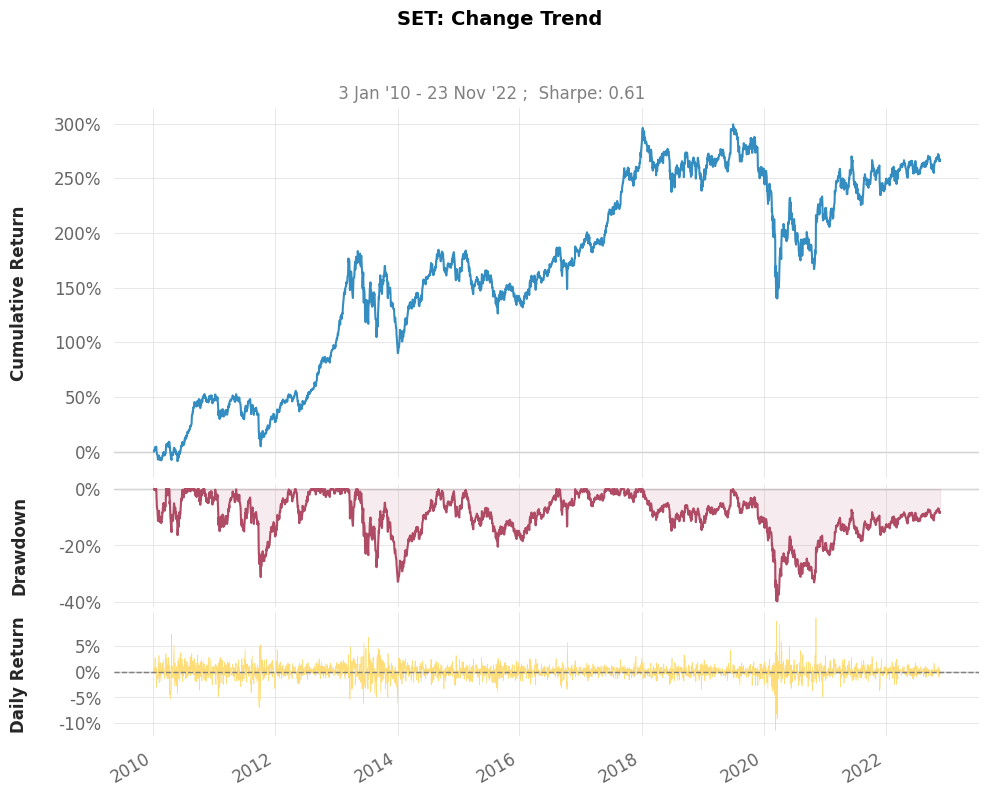

[Performance Metrics]



                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   265.62%     121.83%
CAGR﹪              10.58%      6.37%

Sharpe              0.61        0.47
Prob. Sharpe Ratio  98.43%      95.09%
Sortino             0.88        0.65
Sortino/√2          0.62        0.46
Omega               1.12        1.12

Max Drawdown        -39.9%      -44.29%
Longest DD Days     1238        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.58        0.44

Payoff Ratio        0.93        0.9
Profit Factor       1.12        1.09
Common Sense Ratio  1.15        1.06
CPC Index           0.55        0.53
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.25        4.26
Outlier Loss Ratio  3.52        4.37

MTD                 -0.16%      0.97%
3M                  1.46%       0.5

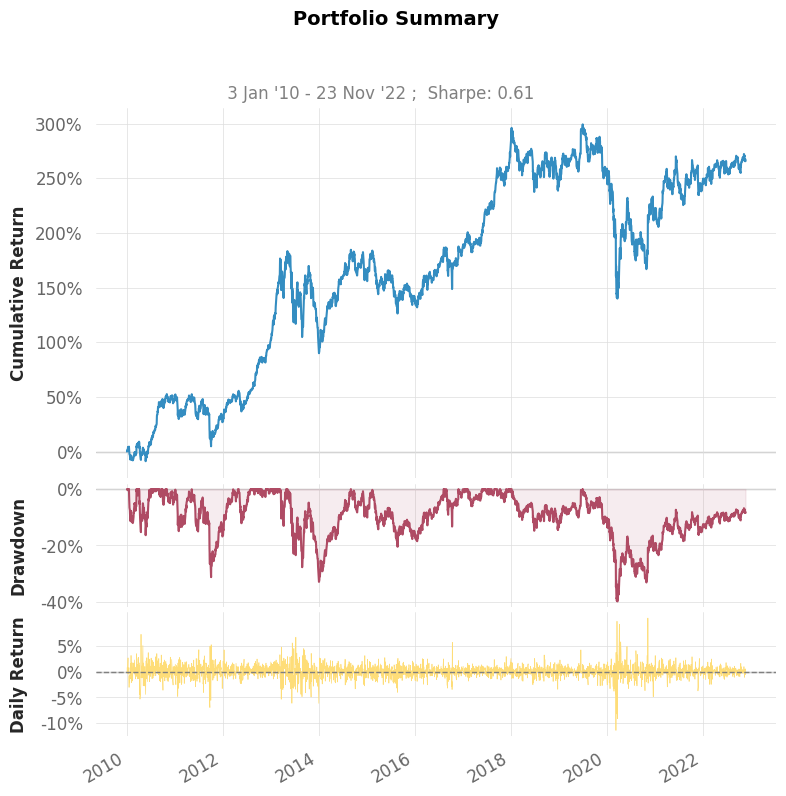

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


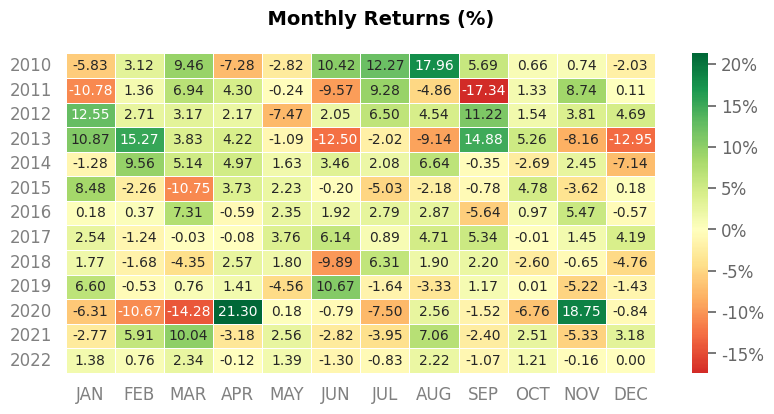

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

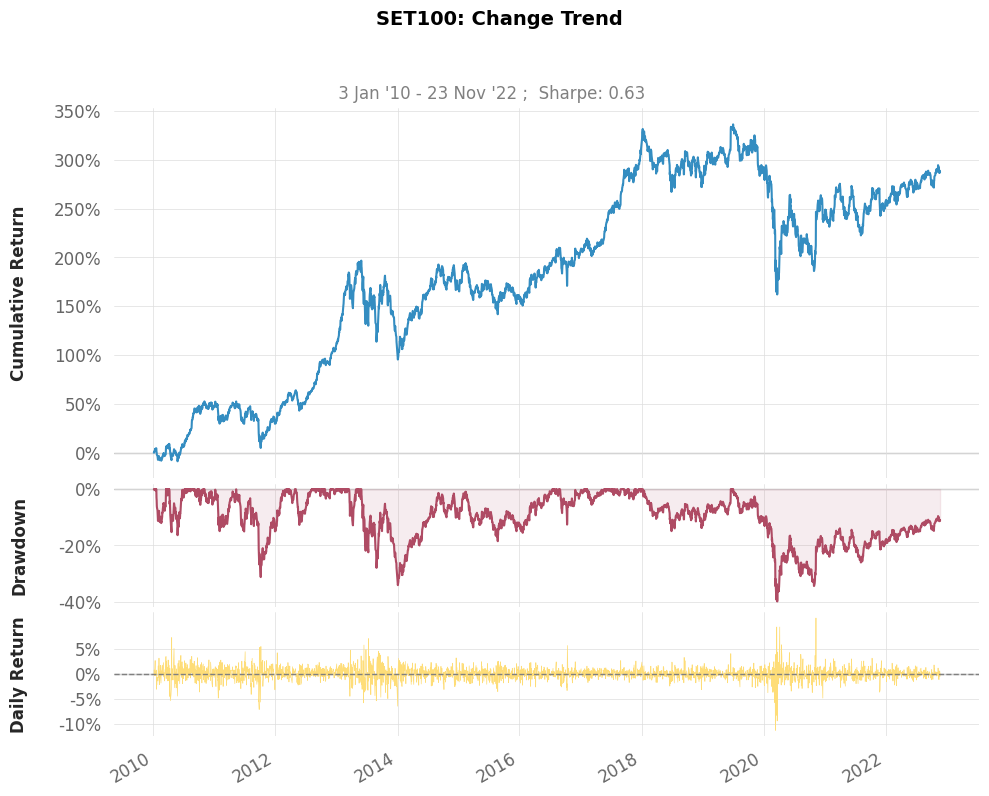

[Performance Metrics]



                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   287.69%     121.83%
CAGR﹪              11.08%      6.37%

Sharpe              0.63        0.47
Prob. Sharpe Ratio  98.7%       95.09%
Sortino             0.91        0.65
Sortino/√2          0.64        0.46
Omega               1.12        1.12

Max Drawdown        -39.93%     -44.29%
Longest DD Days     1238        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.59        0.44

Payoff Ratio        0.94        0.9
Profit Factor       1.12        1.09
Common Sense Ratio  1.17        1.06
CPC Index           0.56        0.53
Tail Ratio          1.04        0.97
Outlier Win Ratio   3.29        4.35
Outlier Loss Ratio  3.63        4.48

MTD                 -0.07%      0.97%
3M                  2.08%       0.5

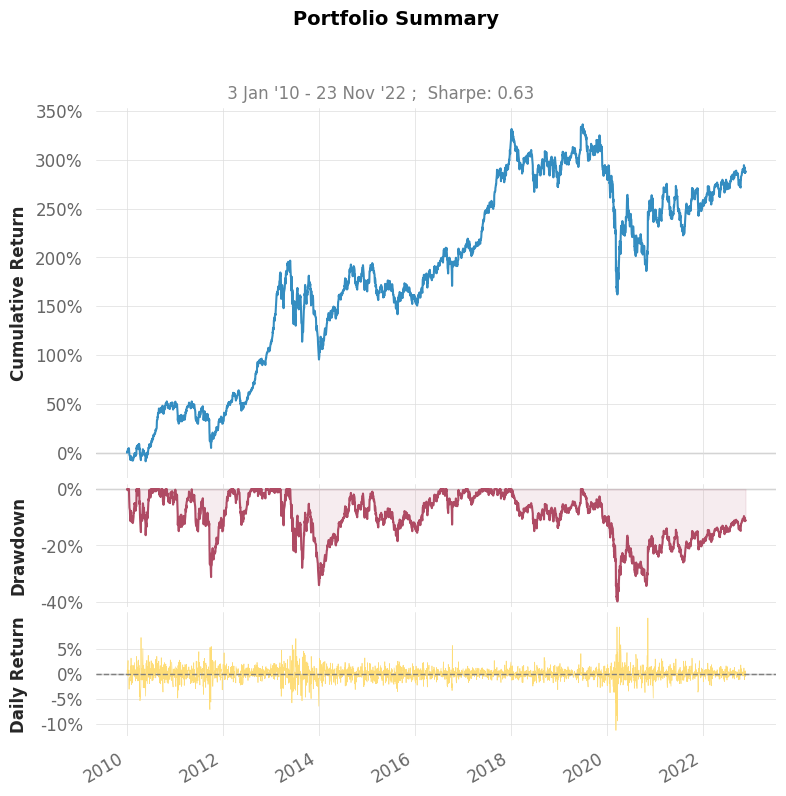

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


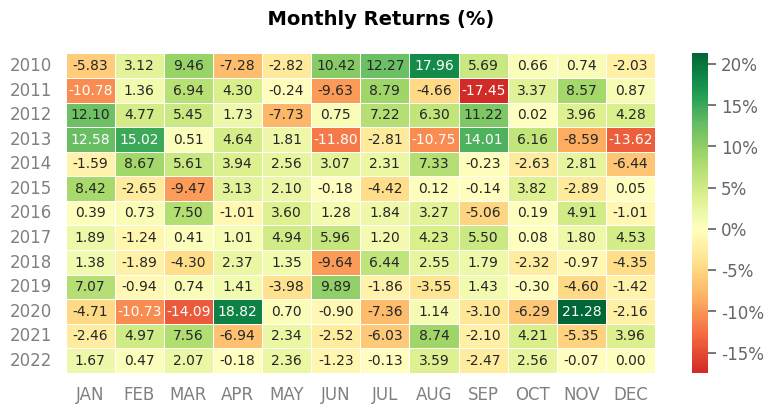

In [ ]:
UNIVERSE = ['SET100']
MODEL_NAME = "Change Trend"

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

sma_10_df = ssc.ta.sma(close_df, 10)
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)

pct_90d_df = ssc.ta.roc(close_df, 90)


# sma cond
sma_10_cond = sma_10_df > sma_20_df
sma_20_cond = sma_20_df < sma_90_df

# pct change 90 days > 10%
pct_90d_cond = pct_90d_df > 10

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = sma_10_cond & sma_20_cond & pct_90d_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
pct_90d_df = pd.DataFrame(np.where((signal_df == True)
         , pct_90d_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking pct change
# 10 highest pct change
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pct_90d_df, quantity=pos_num, ascending=False
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

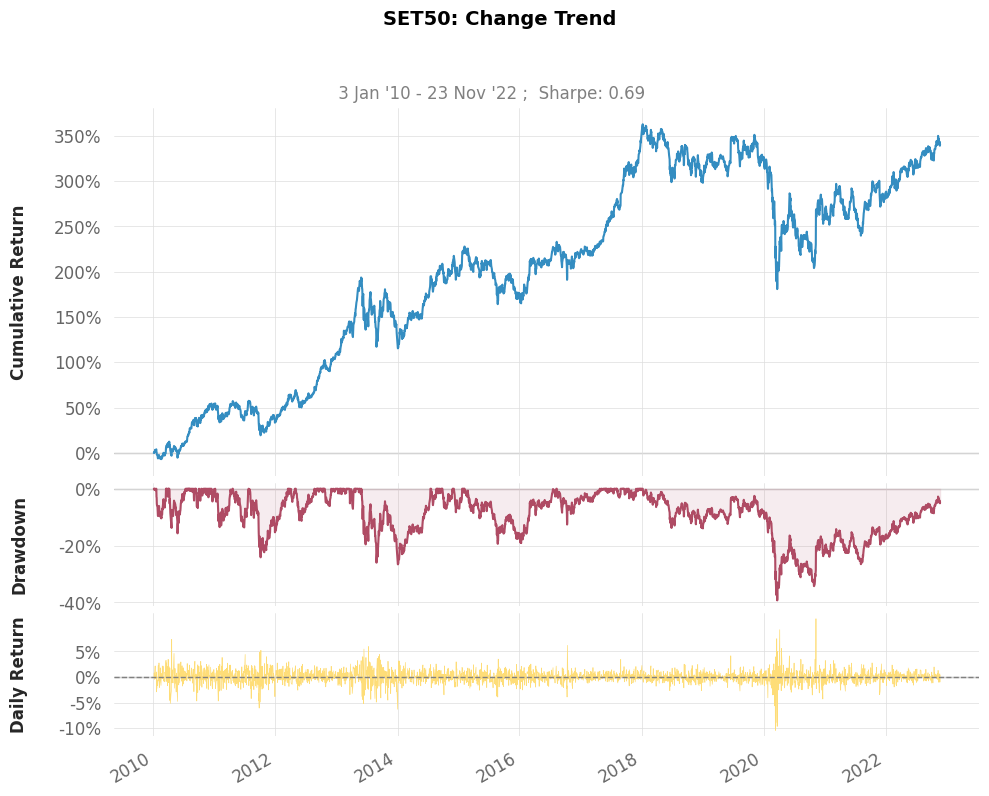

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   340.68%     121.83%
CAGR﹪              12.19%      6.37%

Sharpe              0.69        0.47
Prob. Sharpe Ratio  99.26%      95.09%
Sortino             1.0         0.65
Sortino/√2          0.71        0.46
Omega               1.13        1.13

Max Drawdown        -39.31%     -44.29%
Longest DD Days     1779        1763

Gain/Pain Ratio     0.13        0.09
Gain/Pain (1M)      0.7         0.44

Payoff Ratio        1.0         0.94
Profit Factor       1.13        1.09
Common Sense Ratio  1.25        1.06
CPC Index           0.59        0.55
Tail Ratio          1.11        0.97
Outlier Win Ratio   3.18        4.25
Outlier Loss Ratio  3.69        4.4

MTD                 0.01%       0.97%
3M          

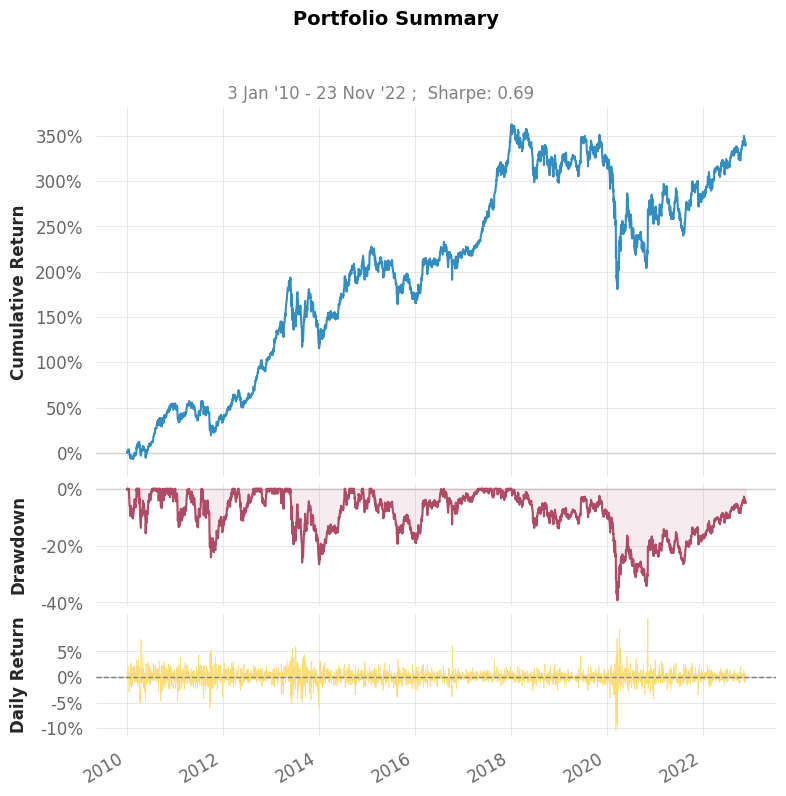

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


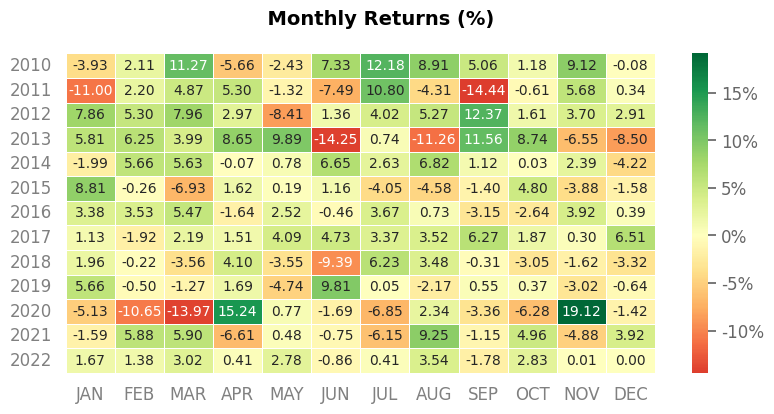

In [ ]:
UNIVERSE = ['SET50']
MODEL_NAME = "Change Trend"

ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

sma_10_df = ssc.ta.sma(close_df, 10)
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)

pct_90d_df = ssc.ta.roc(close_df, 90)


# sma cond
sma_10_cond = sma_10_df > sma_20_df
sma_20_cond = sma_20_df < sma_90_df

# pct change 90 days > 10%
pct_90d_cond = pct_90d_df > 10

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = sma_10_cond & sma_20_cond & pct_90d_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
pct_90d_df = pd.DataFrame(np.where((signal_df == True)
         , pct_90d_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# ranking pct change
# 10 highest pct change
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pct_90d_df, quantity=pos_num, ascending=False
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])